# Conditional DCGANs in pytorch
## Hyperparameters
* Latent space dimensions :- 158
* Labels (Conditional) dimensions :- 18 (Before Embeddings)
* Embeddings dimensions (Combined) :- 98
* Input image dimensions :- (3,64,64)

In [2]:
import torch
import os
import shutil
import tarfile
from torch.utils.data.dataloader import DataLoader,Dataset
from torchvision.datasets import ImageFolder
import torchvision.transforms as tt
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from torchvision.utils import make_grid
from PIL import Image

In [3]:
import torch.nn as nn
import torch.nn.functional as F
from torch.nn.utils.parametrizations import weight_norm
from torch.nn.utils import spectral_norm
from tqdm import tqdm
from torchvision.utils import save_image
from torch.cuda.amp import autocast, GradScaler

In [4]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cpu')

In [9]:
if not os.path.exists("/kaggle/working/data"):
    os.makedirs("/kaggle/working/data")
if not os.path.exists('/kaggle/working/data/cartoonset100k'):
    with tarfile.open('/kaggle/input/cartoonset100k/cartoonset100k.tgz', 'r:gz') as tar:
      tar.extractall(path='/kaggle/working/data')

## Preprocessing

In [10]:
stats = ((0.5,0.5,0.5),(0.5,0.5,0.5))
trfs = tt.Compose([
    tt.Resize(64),
    tt.CenterCrop(64),
    tt.ToTensor(),
    tt.Normalize(*stats)
])
def denorm(image,stats):
  if image.shape[0]>1 and not isinstance(stats[0],(float,int)):
    for i in range(len(image)):
      image[i] = image[i]*stats[1][i]+stats[0][i]
  else:
    image = image*stats[1]+stats[0]
  return image

In [11]:
def move_files(source_dir,target_dir):
  file_names = os.listdir(source_dir)
  for file_name in file_names:
      shutil.move(os.path.join(source_dir, file_name), target_dir)

In [14]:
collected_path = "/kaggle/working/data/Collected"
if (not os.path.exists(collected_path)) or (not len(os.listdir(collected_path))==200000):
    os.makedirs(collected_path,exist_ok=True)
    path ="/kaggle/working/data/cartoonset100k"
    for folder in os.listdir(path):
        fname = os.path.join(path,folder)
        move_files(fname,collected_path)

In [15]:
len(os.listdir("/kaggle/working/data/Collected"))

200000

In [16]:
batch_size = 128
latent_dims = 158
label_dims = 18
labels_dims_after_embedding = 98
images_dims = (3,64,64)

In [17]:
# def make_csv(root,save_path=".",filename="cartoon_faces_data.csv"):
#   rows = []
#   for name in os.listdir(root):
#     if name.endswith('csv'):
#       label_path = os.path.join(root,name)
#       name_without_ext =name.split(".")[0]
#       values = list(pd.read_csv(label_path,header=None)[1])
#       columns = list(pd.read_csv(label_path,header=None)[0])
#       rows.append([name_without_ext]+values)
#   arr = np.array(rows)
#   df = pd.DataFrame(arr,columns=['name']+columns)
#   filename = os.path.join(save_path,filename)
#   df.to_csv(filename,index=False)
#   return filename

In [18]:
filename = "/kaggle/input/cartoonset100k/cartoon_faces_data.csv"
# filename = make_csv("/kaggle/working/data/Collected", "/kaggle/working/")

In [19]:
df = pd.read_csv(filename)
df.head()

,name,eye_angle,eye_lashes,eye_lid,chin_length,eyebrow_weight,eyebrow_shape,eyebrow_thickness,face_shape,facial_hair,hair,eye_color,face_color,hair_color,glasses,glasses_color,eye_slant,eyebrow_width,eye_eyebrow_distance
0,cs3987990578194663858,2,1,0,2,0,6,2,5,7,0,0,6,9,11,0,1,2,0
1,cs9637393511023397973,1,0,0,1,0,12,3,1,14,108,2,1,7,11,6,0,1,0
2,cs7295175591018533170,1,1,1,0,1,12,3,6,14,50,1,8,6,11,2,2,2,1
3,cs14529493472127991924,2,0,1,1,1,4,0,4,10,77,3,3,6,11,4,2,2,2
4,cs15186308562028780971,1,1,1,0,1,8,1,6,7,61,1,1,9,1,3,1,2,0


In [20]:
df.shape

(100000, 19)

In [21]:
def plot_image_grid(image_paths, grid_size=(2, 2), image_size=(128, 128)):

    transform = tt.Compose([
        tt.Resize(image_size),
        tt.ToTensor()
    ])

    images = [transform(Image.open(image_path).convert('RGB')) for image_path in image_paths]

    num_images = grid_size[0] * grid_size[1]
    if len(images) < num_images:
        padding_image = torch.zeros_like(images[0])
        images.extend([padding_image] * (num_images - len(images)))
        
    images_tensor = torch.stack(images[:num_images])

    grid_image = make_grid(images_tensor, nrow=grid_size[1])

    plt.figure(figsize=(grid_size[1] * 2, grid_size[0] * 2))
    plt.imshow(grid_image.permute(1, 2, 0))
    plt.axis('off')
    plt.show()

In [22]:
df.describe()

,eye_angle,eye_lashes,eye_lid,chin_length,eyebrow_weight,eyebrow_shape,eyebrow_thickness,face_shape,facial_hair,hair,eye_color,face_color,hair_color,glasses,glasses_color,eye_slant,eyebrow_width,eye_eyebrow_distance
count,100000.000000,100000.00000,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000
mean,1.002470,0.49842,0.498980,0.997430,0.499490,6.496810,1.500740,3.001470,10.239520,55.019260,2.003230,4.994840,4.482680,7.990990,3.001530,1.000860,1.003640,0.997690
std,0.815555,0.50000,0.500001,0.816217,0.500002,4.024904,1.121165,2.003813,4.704712,32.059605,1.410872,3.158331,2.867525,3.741725,1.997751,0.818466,0.815557,0.816144
min,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,0.00000,0.000000,0.000000,0.000000,3.000000,0.000000,1.000000,6.000000,27.000000,1.000000,2.000000,2.000000,5.000000,1.000000,0.000000,0.000000,0.000000
50%,1.000000,0.00000,0.000000,1.000000,0.000000,6.000000,2.000000,3.000000,13.000000,55.000000,2.000000,5.000000,4.000000,10.000000,3.000000,1.000000,1.000000,1.000000
75%,2.000000,1.00000,1.000000,2.000000,1.000000,10.000000,3.000000,5.000000,14.000000,83.000000,3.000000,8.000000,7.000000,11.000000,5.000000,2.000000,2.000000,2.000000
max,2.000000,1.00000,1.000000,2.000000,1.000000,13.000000,3.000000,6.000000,14.000000,110.000000,4.000000,10.000000,9.000000,11.000000,6.000000,2.000000,2.000000,2.000000


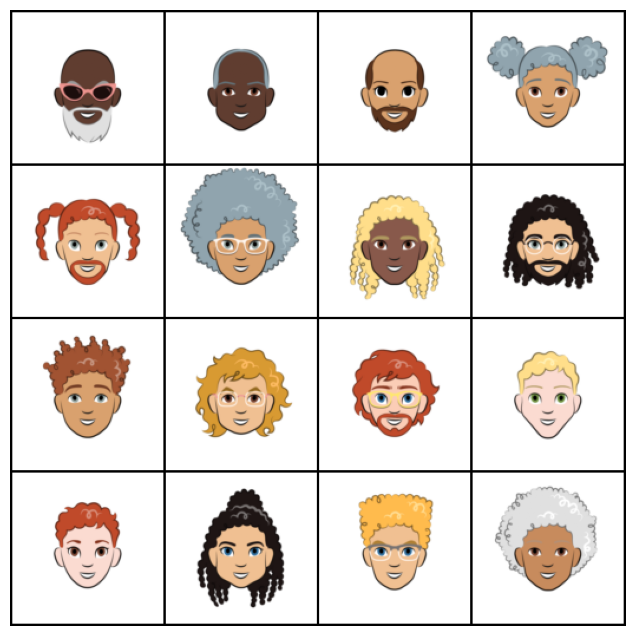

In [23]:
# Checking variation of features
# Perform EDA on each feature
path = "/kaggle/working/data/Collected"
prop = "hair"
image_paths = [f"{path}/{df[df[prop]==i]['name'].iloc[10]}.png" for i in range(df[prop].max()+1)]
plot_image_grid(image_paths, grid_size=(4, 4), image_size=(128, 128))

## Dataset Class

In [24]:
class ImageAndLabels(Dataset):
  def __init__(self,csv_path,transform=lambda x:x):
    df = pd.read_csv(csv_path)
    self.transform = transform
    self.length = df.shape[0]
    self.images = df['name']
    df = df.drop(columns=['name'])
    cats = {}
    catlens = []
    for col in df.columns:
      cats[col]=df[col].max()+1
      catlens.append(df[col].max()+1)
    self.cats = cats
    self.catlens = catlens
    self.labels = torch.from_numpy(df.values).int()

  def __len__(self):
    return self.length

  def __getitem__(self,idx):
    folder_path = "/kaggle/working/data/Collected/"
    image_path = folder_path + self.images[idx] +".png"
    image = Image.open(image_path).convert('RGB')
    image = self.transform(image)
    labels = self.labels[idx]

    return image,labels


In [25]:
train_ds = ImageAndLabels(csv_path = filename,transform=trfs)

In [26]:
train_ds.labels.shape

torch.Size([100000, 18])

In [27]:
train_ds.catlens

[3, 2, 2, 3, 2, 14, 4, 7, 15, 111, 5, 11, 10, 12, 7, 3, 3, 3]

In [28]:
class FakeLabelsGenerator:
  def __init__(self,catlens):
    self.catlens = catlens

  def generate(self,batch_size):
    random_indices = [np.random.randint(0, catlen, size=batch_size) for catlen in self.catlens]
    stacked_indices = np.stack(random_indices, axis=-1)
    stacked_indices =  torch.from_numpy(stacked_indices).int()
    return stacked_indices

In [29]:
flg = FakeLabelsGenerator(train_ds.catlens)

In [30]:
flg.generate(1)

tensor([[ 2,  1,  1,  1,  1, 13,  1,  6, 12, 83,  0,  4,  0,  0,  6,  2,  2,  0]],
       dtype=torch.int32)

In [31]:
train_dl = DataLoader(train_ds,batch_size=128,shuffle=True,pin_memory=True,drop_last=True)

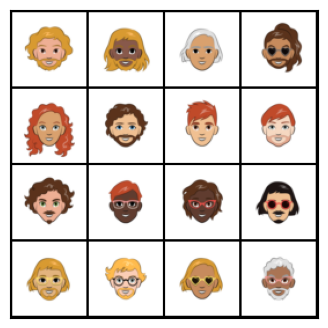

In [32]:
for im,lb in train_dl:
    nmax=16
    fs = int(np.sqrt(nmax))
    grid = make_grid(denorm(im.detach()[:nmax],(0.5,0.5)),nrow=fs).permute(1,2,0)
    fs = int(np.sqrt(nmax))
    fix,ax = plt.subplots(figsize = (fs,fs))
    ax.set_xticks([])
    ax.set_yticks([])
    ax.imshow(grid)
    break

In [33]:
class LatentGenerator:
  def __init__(self,latent_dims,device,constant=False,constant_size=100):
    self.latent_dims = latent_dims
    self.device = device
    if constant:
      self.constant = self.generate(constant_size)
  def generate(self,batch_size):
    Z =  torch.randn(batch_size,self.latent_dims,device=self.device)
    return Z

In [34]:
train_ds.catlens

[3, 2, 2, 3, 2, 14, 4, 7, 15, 111, 5, 11, 10, 12, 7, 3, 3, 3]

## Models

In [35]:
class EmbedAll(nn.Module):
    def __init__(self, catlens=[3, 2, 2, 3, 2, 14, 4, 7, 15, 111, 5, 11, 10, 12, 7, 3, 3, 3]):
        super(EmbedAll, self).__init__()
        self.embeddings = nn.ModuleList(
            [nn.Embedding(catlen, min(50, catlen // 2)) for catlen in catlens]
        )

    def forward(self, labels):
        out = []
        for i, embedding in enumerate(self.embeddings):
            out.append(embedding(labels[:, i]))
        return torch.cat(out, dim=1)

class Discriminator(nn.Module):
  def __init__(self,input_channels=3,feature_dims=64,label_out_dims=98):
    super(Discriminator,self).__init__()
    fd = feature_dims
    lout = label_out_dims
    self.filtering = EmbedAll()
    self.layer1 = nn.Sequential(
        spectral_norm(nn.Conv2d(input_channels ,fd,4,stride=2,padding=1,bias=False)),
        nn.BatchNorm2d(fd),
        nn.Mish(inplace=True))

    self.layers= nn.Sequential(
        spectral_norm(nn.Conv2d(fd+lout ,fd,3,stride=1,padding=1,bias=False)),
        nn.BatchNorm2d(fd),
        nn.Mish(inplace=True),

        spectral_norm(nn.Conv2d(fd ,2*fd,4,stride=2,padding=1,bias=False)),
        nn.BatchNorm2d(2*fd),
        nn.Mish(inplace=True),

        spectral_norm(nn.Conv2d(2*fd,4*fd,4,stride=2,padding=1,bias=False)),
        nn.BatchNorm2d(4*fd),
        nn.Mish(inplace=True),

        spectral_norm(nn.Conv2d(4*fd,8*fd,4,stride=2,padding=1,bias=False)),
        nn.BatchNorm2d(8*fd),
        nn.Mish(inplace=True) )

    self.final = nn.Sequential(
        nn.Conv2d( 8*fd ,1,4,stride=1,padding=0,bias=False),
        nn.Flatten())

  def forward(self,image,label, return_features=False):
    label = self.filtering(label)
    label = label.unsqueeze(2).unsqueeze(3)
    label = label.repeat(1, 1, 32, 32) # b, 64, 32, 32
    image = self.layer1(image) # b,64,32,32
    image_and_label = torch.cat([image, label], dim=1)

    features = self.layers(image_and_label)
    validity = self.final(features)
    if return_features:
      return validity,features
    return validity

class Generator(nn.Module):
    def __init__(self, input_dims=256,feature_dims=64):
        super(Generator, self).__init__()
        input_dims = 256
        fd = feature_dims
        self.filtering = EmbedAll()
        self.model = nn.Sequential(
        weight_norm(nn.ConvTranspose2d(input_dims,8*fd,4,stride=1,padding=0,bias=False)),
        nn.BatchNorm2d(8*fd),
        nn.Mish(inplace=True),

        weight_norm(nn.ConvTranspose2d(8*fd,4*fd,4,stride=2,padding=1,bias=False)),
        nn.BatchNorm2d(4*fd),
        nn.Mish(inplace=True),

        weight_norm(nn.ConvTranspose2d(4*fd,2*fd,4,stride=2,padding=1,bias=False)),
        nn.BatchNorm2d(2*fd),
        nn.Mish(inplace=True),

        weight_norm(nn.ConvTranspose2d(2*fd,fd,4,stride=2,padding=1,bias=False)),
        nn.BatchNorm2d(fd),
        nn.Mish(inplace=True),

        weight_norm(nn.ConvTranspose2d(fd,3,4,stride=2,padding=1,bias=False)),
        nn.Tanh()
        )

    def forward(self, z, labels):
      batch_size = labels.size(0)
      filtered = self.filtering(labels)
      l_and_z = torch.cat([filtered, z], dim=1).view(batch_size, -1, 1, 1)
      out = self.model(l_and_z)
      return out

In [38]:
def weights_init(m):
  if isinstance(m,nn.Conv2d) or isinstance(m,nn.ConvTranspose2d):
    torch.nn.init.normal_(m.weight,0.0,0.2)
  elif isinstance(m,nn.BatchNorm2d):
    torch.nn.init.constant_(m.weight, 1.0)
    torch.nn.init.constant_(m.bias,0.0)

In [39]:
disc = Discriminator(input_channels=3).to(device)
disc = disc.apply(weights_init)
gen = Generator().to(device)
gen = gen.apply(weights_init)

In [40]:
ltg = LatentGenerator(158,device,True,64)
flg = FakeLabelsGenerator(train_ds.catlens)

In [41]:
def get_grid(im_batch,nmax=64):
  return make_grid(denorm(im_batch.detach()[:nmax],(0.5,0.5)),nrow=8).permute(1,2,0)

def plot_grid(grid,nmax=64):
  fs = int(np.sqrt(nmax))
  fix,ax = plt.subplots(figsize = (fs,fs))
  ax.set_xticks([]);ax.set_yticks([])
  ax.imshow(grid)

def show_batch(loader,nmax=64):
  for im_batch,_ in loader:
    plot_grid(get_grid(im_batch,nmax))
    break

torch.Size([64, 158])
torch.Size([64, 3, 64, 64])


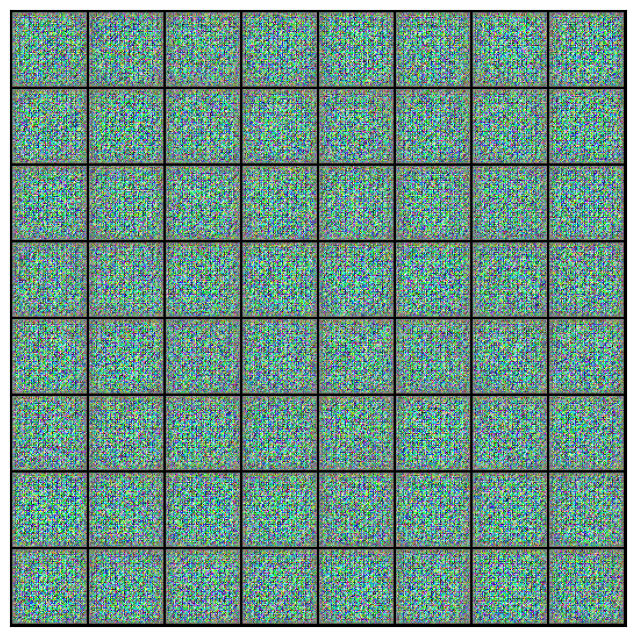

In [42]:
with torch.no_grad():
  fake_images = gen(ltg.constant.to(device),flg.generate(ltg.constant.size(0)).to(device))
  print(ltg.constant.shape)
  print(fake_images.shape)
  grid = get_grid(fake_images)
  plot_grid(grid.cpu())

## Trainer Class

In [43]:
class GANTrainer:
    def __init__(self, generator, discriminator,
                 opt_g, opt_d, latent_dims,label_dims,
                 batch_size, device, save_path,
                 denorm_func,
                 fm_loss_wt,fl_generator,
                 ):

        self.history = None
        self.Generator = generator.to(device)
        self.Discriminator = discriminator.to(device)
        self.opt_g = opt_g
        self.opt_d = opt_d
        self.latent_dims = latent_dims
        self.label_dims = label_dims
        self.device = device
        self.flg = fl_generator
        self.constant_latent = self.generate_latent(64)
        self.constant_labels = self.flg.generate(64)
        self.batch_size = batch_size
        self.save_path = save_path
        self.denorm = denorm_func
        self.scaler_g = GradScaler()
        self.scaler_d = GradScaler()
        self.current_epoch = 0
        self.fm_loss_wt = fm_loss_wt
        os.makedirs(save_path, exist_ok=True)
        os.makedirs(save_path+"/random", exist_ok=True)
        self.save_samples(save_path, -1, self.constant_latent,self.constant_labels)
        self.save_samples(save_path+"/random", -1, self.generate_latent(64),self.flg.generate(64))

    def generate_targets(self, batch_size, label):
        return torch.ones(batch_size, 1, device=self.device) * label

    def generate_latent(self, batch_size):
        return torch.randn(batch_size, self.latent_dims, device=self.device)

    @staticmethod
    @torch.no_grad()
    def get_score(preds):
        return torch.mean(preds).item()

    def train_discriminator(self, real_images,real_labels):
        self.Discriminator.train()
        self.Generator.eval()
        optimizer = self.opt_d
        scaler = self.scaler_d
        batch_size = real_images.size(0)
        self.batch_size = batch_size

        real_images = real_images.to(self.device)  # X
        real_labels = real_labels.to(self.device)  # y
        real_targets = self.generate_targets(batch_size, 1.0)  # 1

        latent_vector = self.generate_latent(batch_size)  # Z
        fake_labels = real_labels # y
        fake_targets = self.generate_targets(batch_size, 0.0)  # 0

        optimizer.zero_grad()
        with autocast():
            real_preds = self.Discriminator(real_images,real_labels)  # D(X/y)
            real_loss = F.binary_cross_entropy_with_logits(real_preds, real_targets)  # -E[log(D(X/y))]
            fake_images = self.Generator(latent_vector, fake_labels)
            fake_preds = self.Discriminator(fake_images.detach(),fake_labels)  # D(G(Z/y))
            fake_loss = F.binary_cross_entropy_with_logits(fake_preds, fake_targets)  # -E[log(1-D(G(Z/y)))]
            total_loss = (real_loss + fake_loss)/2  # -E[log(D(X/y))]-E[log(1-D(G(Z/y)))]

        scaler.scale(total_loss).backward()
        scaler.step(optimizer)
        scaler.update()

        real_score = self.get_score(F.sigmoid(real_preds))  # % real predicted as real
        fake_score = self.get_score(F.sigmoid(fake_preds))  # % fake predicted as fake

        return total_loss.item(), real_score, fake_score

    def train_generator(self, images, labels):
        self.Generator.train()
        self.Discriminator.train()
        batch_size = self.batch_size
        optimizer = self.opt_g
        scaler = self.scaler_g

        latent_vector = self.generate_latent(batch_size)  # Z
        targets = self.generate_targets(batch_size, 1.0)  # 1
        images = images.to(self.device)
        labels = labels.to(self.device) # y'

        optimizer.zero_grad()

        with autocast():
          with torch.no_grad():
            _, real_features = self.Discriminator(images, labels, True)
          fake_images = self.Generator(latent_vector, labels)
          preds, fake_features = self.Discriminator(fake_images, labels, True)  # D(G(Z/y))
          bceloss = F.binary_cross_entropy_with_logits(preds, targets)  # -E[D(G(Z/y))]
          fm_loss = F.mse_loss(fake_features,real_features.detach())
          if self.current_epoch>=5: # Better features are learnt upto 5 epochs, try tunning it with different values.
            loss = bceloss+self.fm_loss_wt*fm_loss
          else:
            loss = bceloss+0.01*self.fm_loss_wt*fm_loss

        scaler.scale(loss).backward()
        scaler.step(optimizer)
        scaler.update()

        return bceloss.item(), fm_loss.item()

    @torch.no_grad()
    def save_samples(self, path, index, latent_vector,labels, show=False, print_message=False):
        if self.current_epoch > 5:
            self.Generator.eval()
        fake_labels = labels.to(self.device)

        fake_images = self.Generator(latent_vector,fake_labels)
        folder_path = path
        filename = "generated-images{0:0=4d}.png".format(index + 1)
        save_image(self.denorm(fake_images, (0.5, 0.5)), os.path.join(folder_path, filename), nrow=8)
        if print_message:
            print("Saving", filename)
        if show:
            fig, ax = plt.subplots(figsize=(8, 8))
            ax.set_xticks([])
            ax.set_yticks([])
            ax.imshow(make_grid(self.denorm(fake_images, (0.5, 0.5)).cpu().detach(), nrow=8).permute(1, 2, 0))

    def fit(self, dataloader, epochs):
        if self.device.type == 'cuda':
            torch.cuda.empty_cache()

        self.history = {"losses_g": [],
                        "losses_d": [],
                        "fm_loss": [],
                        "real_scores": [],
                        "fake_scores": [],
                        "epochs": []}
        loss_g = 0
        loss_d = 0
        fm_loss = 0
        real_score = 0
        fake_score = 0

        for epoch in range(epochs):

            torch.cuda.empty_cache()
            self.current_epoch = epoch
            running_loss_d = []
            running_loss_g = []
            running_fm_loss = []
            running_real_score = []
            running_fake_score = []

            for real_images, real_labels in tqdm(dataloader):

                loss_d, real_score, fake_score = self.train_discriminator(real_images,real_labels)
                loss_g, fm_loss = self.train_generator(real_images,real_labels)

                running_loss_d.append(loss_d)
                running_loss_g.append(loss_g)
                running_fm_loss.append(fm_loss)
                running_real_score.append(real_score)
                running_fake_score.append(fake_score)

            self.history["losses_g"].append(np.mean(running_loss_g))
            self.history["losses_d"].append(np.mean(running_loss_d))
            self.history["fm_loss"].append(np.mean(running_fm_loss))
            self.history["real_scores"].append(np.mean(running_real_score))
            self.history["fake_scores"].append(np.mean(running_fake_score))
            self.history["epochs"].append(epoch)
            # wandb.log({"losses_g": loss_g, "losses_d": loss_d}) # --> Log process on Wandb

            print("Epoch [{}/{}], loss_g: {:.4f}, loss_d: {:.4f}, fm_loss: {:.4f}, real_score: {:.4f}, fake_score: {:.4f}".format(
                epoch + 1, epochs, loss_g, loss_d, fm_loss, real_score, fake_score))
            
            # Track generated samples with constant latent and labels
            self.save_samples(path = self.save_path, index =  epoch, latent_vector= self.constant_latent, labels=self.constant_labels, show =False, print_message=True)
            # Track generated samples with random latent and labels
            self.save_samples(path = self.save_path+"/random", index =  epoch, latent_vector= self.generate_latent(64), labels=self.flg.generate(64), show =False, print_message=False)

In [44]:
disc = Discriminator(input_channels=3).to(device)
disc = disc.apply(weights_init)
gen = Generator().to(device)
gen = gen.apply(weights_init)

In [51]:
# For resuming training
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
if os.path.isfile('/kaggle/working/Projects/MishcDCGAN-100k-Embedding/generator.pt'):
    print(disc.load_state_dict(torch.load('/kaggle/working/Projects/MishcDCGAN-100k-Embedding/discriminator.pt', map_location = device)))
if os.path.isfile('/kaggle/working/Projects/MishcDCGAN-100k-Embedding/discriminator.pt'):
    print(gen.load_state_dict(torch.load('/kaggle/working/Projects/MishcDCGAN-100k-Embedding/generator.pt', map_location = device)))

<All keys matched successfully>
<All keys matched successfully>


In [52]:
opt_d = torch.optim.Adam(disc.parameters(), lr=0.0002, betas=(0.5, 0.999))
opt_g = torch.optim.Adam(gen.parameters(), lr=0.00015, betas=(0.5, 0.999))

In [53]:
gnt = GANTrainer(generator=gen, discriminator=disc,
                 opt_g=opt_g, opt_d=opt_d, 
                 latent_dims=158,label_dims=18,
                 batch_size=128, device=device, 
                 save_path = "/kaggle/working/Generated",
                 denorm_func = denorm,
                 fm_loss_wt = 0.1,
                 fl_generator = flg,
                 )

/opt/conda/lib/python3.10/site-packages/torch/cuda/amp/grad_scaler.py:125: UserWarning: torch.cuda.amp.GradScaler is enabled, but CUDA is not available.  Disabling.
  warnings.warn(


## Model Training

In [81]:
train = False #<-- Change it to True to start training.
if os.path.isfile('/kaggle/working/Projects/MishcDCGAN-100k-Embedding/gan_trainer.pt') and not train:
    gnt = torch.load('/kaggle/working/Projects/MishcDCGAN-100k-Embedding/gan_trainer.pt',map_location=device)
    gnt.Generator = gen
    gnt.Discriminator = disc
else:
    gnt.fit(train_dl,1)

## Plotting score and loss curvves

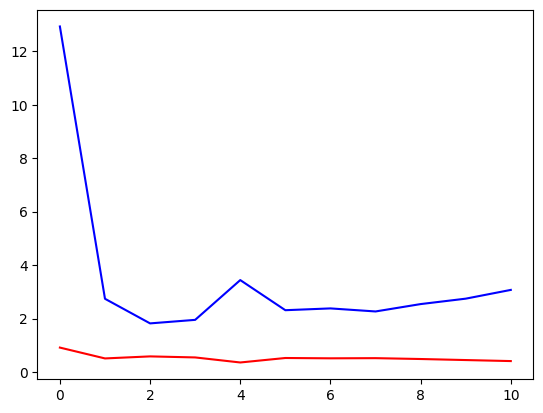

In [77]:
plt.plot(gnt.history['epochs'],gnt.history['losses_d'],c='r')
plt.plot(gnt.history['epochs'],gnt.history['losses_g'],c='b')

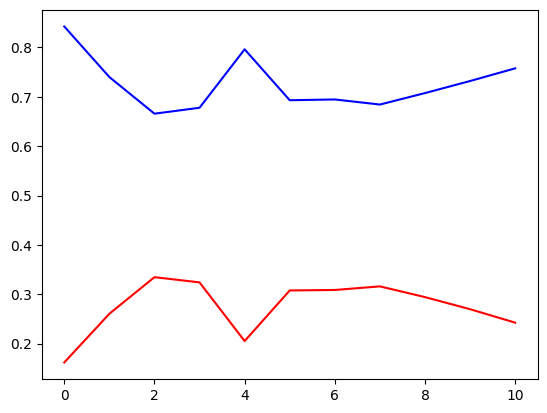

In [78]:
plt.plot(gnt.history['epochs'],gnt.history['real_scores'],c='b')
plt.plot(gnt.history['epochs'],gnt.history['fake_scores'],c='r')

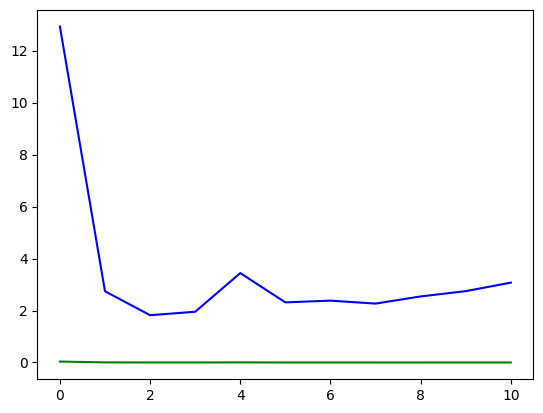

In [79]:
plt.plot(gnt.history['epochs'],gnt.history['losses_g'],c='b')
plt.plot(gnt.history['epochs'],gnt.history['fm_loss'],c='g')

## Saving project

In [84]:
# project_name = "MishcDCGAN-100k-Embedding"

In [85]:
# def copy_images(source_dir,destination_dir):
#   os.makedirs(destination_dir, exist_ok=True)
#   shutil.copytree(source_dir, destination_dir, dirs_exist_ok=True)
#   print("Files copied successfully!")

In [86]:
# def save_project(gnt):
#   gen = gnt.Generator
#   disc = gnt.Discriminator
#   save_path = os.path.join("/kaggle/working/Projects",project_name)
#   os.makedirs(save_path,exist_ok=True)
#   gnt.save_samples(path =save_path, index =  0, latent_vector= gnt.constant_latent, labels=gnt.constant_labels, show =True)
#   torch.save(gen.state_dict(),save_path+"/generator.pt")
#   torch.save(disc.state_dict(), save_path + "/discriminator.pt")
#   gnt.Generator = None
#   gnt.Discriminator = None
#   torch.save(gnt, save_path + "/gan_trainer.pt")
#   gnt.Generator = gen
#   gnt.Discriminator = disc

#   im_path = os.path.join(save_path,"generated_images")
#   os.makedirs(im_path,exist_ok=True)
#   copy_images("/kaggle/working/Generated",im_path)

In [87]:
# save_project(gnt)

In [88]:
# def compress_files(folder_path, output_filename, output_path):
#   """
#   Compresses files in a given folder into a tar.gz archive.

#   Args:
#     folder_path: Path to the folder containing the files to compress.
#     output_filename: Name of the output tar.gz file.
#     output_path: Path to the directory where the compressed file will be saved.
#   """
#   with tarfile.open(os.path.join(output_path, output_filename + ".tar.gz"), "w:gz") as tar:
#     tar.add(folder_path, arcname=os.path.basename(folder_path))


In [89]:
# compress_files("/kaggle/working/Projects/MishcDCGAN-100k-Embedding",project_name,"/kaggle/working/")

## Testing the generator

In [74]:
df.head()

,name,eye_angle,eye_lashes,eye_lid,chin_length,eyebrow_weight,eyebrow_shape,eyebrow_thickness,face_shape,facial_hair,hair,eye_color,face_color,hair_color,glasses,glasses_color,eye_slant,eyebrow_width,eye_eyebrow_distance
0,cs3987990578194663858,2,1,0,2,0,6,2,5,7,0,0,6,9,11,0,1,2,0
1,cs9637393511023397973,1,0,0,1,0,12,3,1,14,108,2,1,7,11,6,0,1,0
2,cs7295175591018533170,1,1,1,0,1,12,3,6,14,50,1,8,6,11,2,2,2,1
3,cs14529493472127991924,2,0,1,1,1,4,0,4,10,77,3,3,6,11,4,2,2,2
4,cs15186308562028780971,1,1,1,0,1,8,1,6,7,61,1,1,9,1,3,1,2,0


In [54]:
class ImageGenerator:
    def __init__(self,Generator,catlens,latent_dims,device):
        self.gen = Generator
        self.catlens = catlens
        self.latent_dims = latent_dims
        self.device = device
    
    def get_noise(self,noise_dims=158):        
        return torch.randn(1, noise_dims, device=self.device)
    
    def check_labels(self,labels):
        for i,(label,catlen) in enumerate(zip(labels,self.catlens)):
            if label>=catlen:
                raise ValueError(f"[{i}] th label is exceeding maximum value! ")
        return True
    
    @torch.no_grad()
    def generate(self,labels,plot=True):
        if isinstance(labels,dict):
            labels = list(labels.values())
        self.gen.eval()
        if self.check_labels(labels):
            noise = self.get_noise()
            labels = torch.tensor(labels).unsqueeze(0).to(device)
            image = denorm(self.gen(noise,labels),(0.5,0.5)).squeeze(0).permute(1,2,0).cpu()
            if plot:
                plt.imshow(image)
                return None
            return image

In [55]:
ig = ImageGenerator(gen,train_ds.catlens,158,device)

In [56]:
train_ds.cats

{'eye_angle': 3,
 'eye_lashes': 2,
 'eye_lid': 2,
 'chin_length': 3,
 'eyebrow_weight': 2,
 'eyebrow_shape': 14,
 'eyebrow_thickness': 4,
 'face_shape': 7,
 'facial_hair': 15,
 'hair': 111,
 'eye_color': 5,
 'face_color': 11,
 'hair_color': 10,
 'glasses': 12,
 'glasses_color': 7,
 'eye_slant': 3,
 'eyebrow_width': 3,
 'eye_eyebrow_distance': 3}

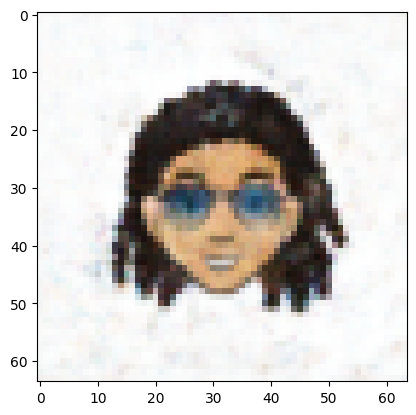

In [73]:
ig.generate({'eye_angle': 0,
 'eye_lashes': 0,
 'eye_lid': 0,
 'chin_length': 0,
 'eyebrow_weight': 0,
 'eyebrow_shape': 3,
 'eyebrow_thickness': 0,
 'face_shape': 0,
 'facial_hair': 0,
 'hair': 7,
 'eye_color': 1,
 'face_color':5 ,
 'hair_color': 7,
 'glasses': 0,
 'glasses_color': 2,
 'eye_slant': 0,
 'eyebrow_width': 0,
 'eye_eyebrow_distance':0})

## Key Insights
* Training a GAN is really a challenging problem due to training instability.
* When using DCGANs use of linear layers should be avoided.
* Mish activation performs slightly better than ReLU or LeakyReLU, at cost of computations.
* Use Embeddings instead of one hot encodings to reduce the cardinality and sparsity (High sparsity -> High unstability in training)
* Including Feature matching loss (for generator) helps in training.
* Use of spectral norm in Discriminator's Conv2d layers helps stabilizing training.
* I have tried Instance norm instead of BatchNorm in Discriminator, but it didn't work (BatchNorm's better).
* Training GANs conditionally helps reducing Mode Collapse issue.

In [90]:
def remove_file(filename_path):
    if os.path.exists(file_path):
        os.remove(file_path)
        print(f"File '{file_path}' has been removed.")
    else:
        print(f"File '{file_path}' does not exist.")

In [91]:
def remove_dir(dir_path):
    if os.path.exists(dir_path):
        shutil.rmtree(dir_path)
        print(f"Directory '{dir_path}' has been removed.")
    else:
        print(f"Directory '{dir_path}' does not exist.")